Resizing to 300 x 300
Loaded /Users/iskander/Downloads/spider.jpg, with dimensions 300 x 300 (70.27% non-zero entries)


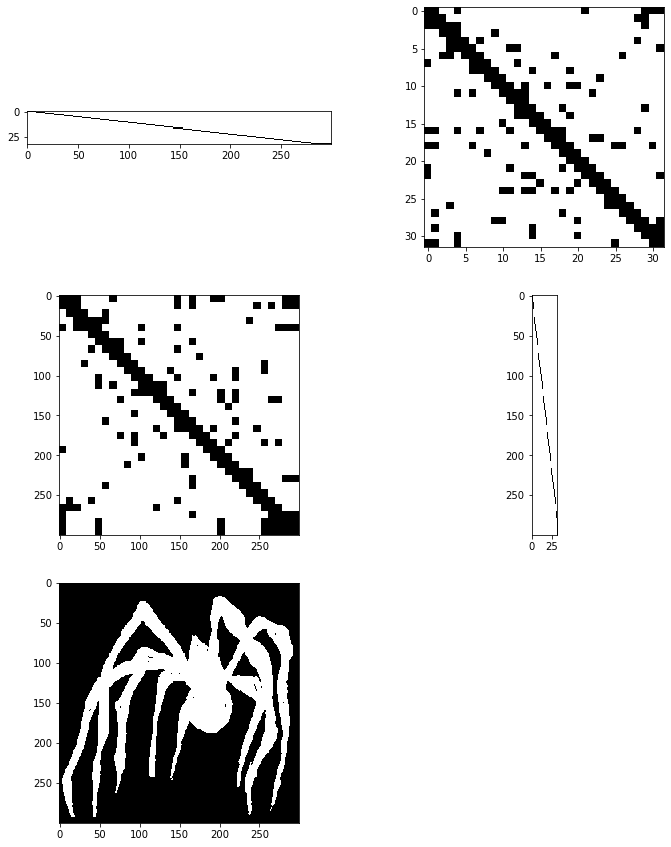

Iter #1, starting accuracy: 0.862
# updates in matrices: A=292, B=1, C=234


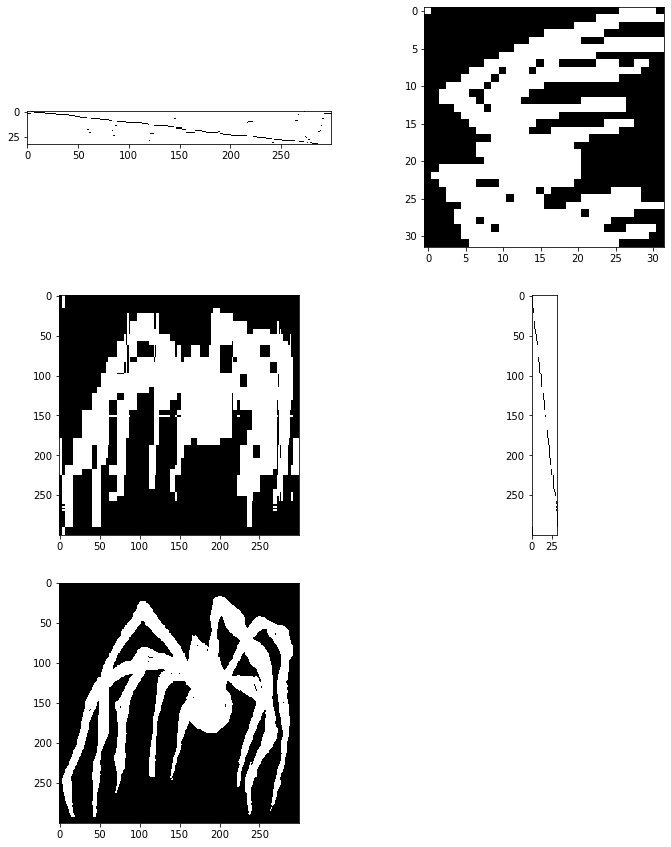

-- new accuracy at end of iter #1: 0.902
Iter #2, starting accuracy: 0.902
# updates in matrices: A=100, B=5, C=40


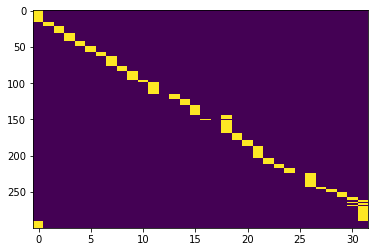

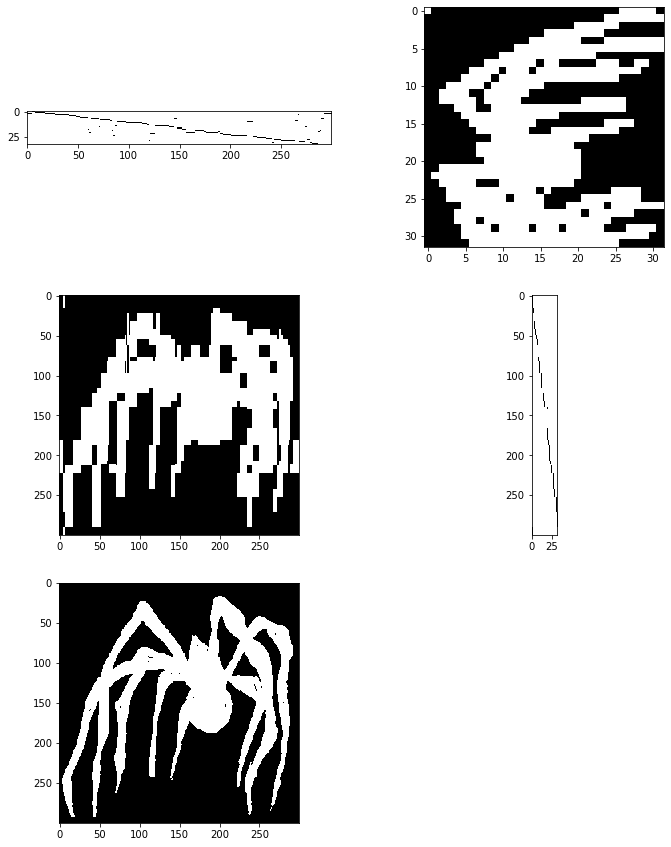

-- new accuracy at end of iter #2: 0.907
Iter #3, starting accuracy: 0.907
# updates in matrices: A=16, B=1, C=22


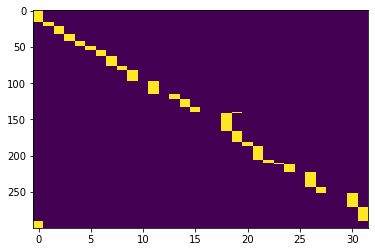

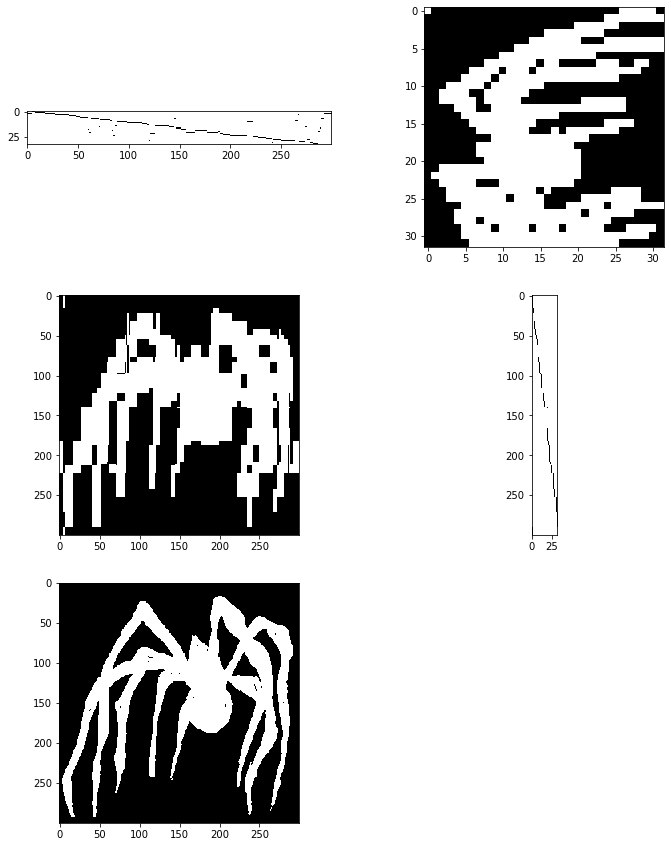

-- new accuracy at end of iter #3: 0.908
Iter #4, starting accuracy: 0.908
# updates in matrices: A=14, B=1, C=4


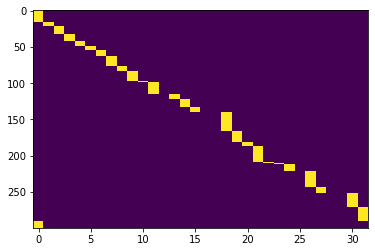

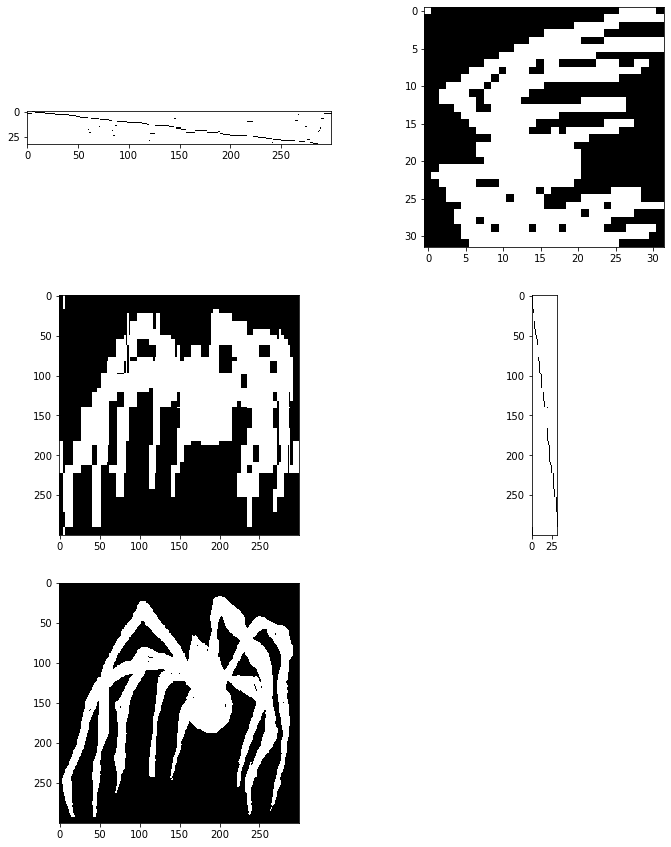

-- new accuracy at end of iter #4: 0.908
Iter #5, starting accuracy: 0.908
# updates in matrices: A=0, B=0, C=0
-- Stopping early since matrices stopped changing


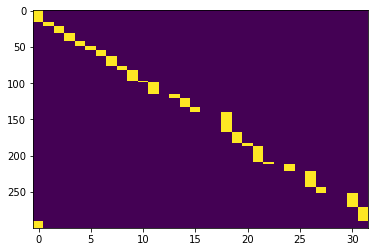

In [11]:
%matplotlib inline
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

# X_true = (mpimg.imread("/Users/iskander/Downloads/stinkbug.webp")[:, :, 1] > 120)[50:-50, 100:-100]
filename = "/Users/iskander/Downloads/spider.jpg"
# X_true = (mpimg.imread("/Users/iskander/Downloads/face.jpg")[:, :] > 120)[150:800, 150:650]
# X_true = (mpimg.imread("/Users/iskander/Downloads/trees.jpg")[:, :] > 120)
# X_true = (mpimg.imread("/Users/iskander/Downloads/m51.jpg")[:, :] > 120)[100:350, 180:430]
import matplotlib.colors

# img = mpimg.imread("/Users/iskander/Downloads/albers.jpg")
# img = mpimg.imread("/Users/iskander/Downloads/tate.jpg")
# X_true = ((((img[:, :, 0].astype(float) + img[:, :, 1].astype(float) + img[:, :, 2].astype(float))) / 3)  > 100)
img = Image.open(filename)

img_x, img_y = img.size
ratio = img_y / img_x

new_img_x = img_x
new_img_y = img_y

if img_x > 300:
    new_img_x = 300
    new_img_y = int(new_img_x * ratio)
    print("Resizing to %d x %d" % (new_img_x, new_img_y))
elif img_y > 300:
    new_img_y = 300
    new_img_x = new_img_y / ratio
    print("Resizing to %d x %d" % (new_img_x, new_img_y))
    
if new_img_x != img_x or new_img_y != img_y:
    img = img.resize( (new_img_x, new_img_y), resample=Image.BICUBIC)
img_data = np.array(img)
X_true = ((((img_data[:, :, 0].astype(float) + img_data[:, :, 1].astype(float) + img_data[:, :, 2].astype(float))) / 3)  > 100)

print("Loaded %s, with dimensions %d x %d (%0.2f%% non-zero entries)" % (
    filename, X_true.shape[0], X_true.shape[1], 100 * X_true.sum() / (X_true.shape[0] * X_true.shape[1])))

m, n  = X_true.shape
f, p = 32, 32

def fix_tie_up(X_binary):
    f, p = X_binary.shape
    X_binary = X_binary.copy()
    for i in range(p):
        if X_binary.sum(axis=0)[i] == 0:
            X_binary[np.random.randint(0, f), i] = True
        if X_binary.sum(axis=0)[i] == X_binary.shape[0]:
            X_binary[np.random.randint(0, f), i] = False
    # though not strictly necessary, also get rid of empty/full rows when possible
    for empty_row_idx in np.where(X_binary.sum(axis=1) == 0)[0]:
        colsums = X_binary.sum(axis=0)
        
        valid_cols = np.where(colsums < (f - 1))[0]
        if len(valid_cols) > 0:
            col_idx = np.random.choice(valid_cols)
            X_binary[empty_row_idx, col_idx] = True
    for full_row_idx in np.where(X_binary.sum(axis=1) == p)[0]:
        colsums = X_binary.sum(axis=0)
        
        valid_cols = np.where(colsums > 1)[0]
        if len(valid_cols) > 0:
            col_idx = np.random.choice(valid_cols)
            X_binary[full_row_idx, col_idx] = False
    return X_binary

def project_tie_up(X_T):
    X = X_T.T.copy()
    m = np.median(X[:])
    X_binary = X > m
    for i in range(X_binary.shape[1]):
        if X_binary.sum(axis=0)[i] == 0:
            col_values = X[:, i]
            max_idx = np.argmax(col_values)
            
            X_binary[max_idx, i] = True
        if X_binary.sum(axis=0)[i] == X_binary.shape[0]:
            col_values = X[:, i]
            min_idx = np.argmin(col_values)
            X_binary[min_idx, i] = False
    return X_binary.T

def init_ident_rectangle(nrows, ncols, band=False):
    result = np.zeros((nrows, ncols), dtype=bool)
    max_val = max(nrows, ncols)
    for i in range(max_val):
        result[i % nrows, i % ncols] = True
        if band:
            result[i % nrows, (i + 1) % ncols] = True
            result[(i + 1) % nrows, i % ncols] = True
            
    return result

def init_threading_ramp(nrows, ncols):
    assert ncols > nrows
    cols_per_segment = ncols // nrows
    result = np.zeros((nrows, ncols), dtype=bool)
    for i in range(ncols):
        idx = min(nrows - 1, i // cols_per_segment)
        result[idx, i] = True
    return result

def rand_tie_up(nrows, ncols, p=0.4):
    return np.random.rand(nrows, ncols) <= p

def rand_threading(nrows, ncols):
    result = np.zeros(shape=(nrows, ncols), dtype=bool)
    indices = np.random.randint(0, nrows, ncols)
    assert indices.shape == (ncols,)
    for col in range(ncols):
        result[indices[col], col] = True
    return result

def rand_treadling(nrows, ncols):
    result = rand_threading(ncols, nrows)
    return result.T


# X_square = np.zeros(shape=(m, n), dtype=bool)
# X_square[2*m//9:7*m//9, 4*n//9:5*n//9] = True
# X_square[m//3:2*m//3, n//3:2*n//3] = True
# X_square[3*m//5:4*m//5, 2*n//7:5*n//7] = True
# rand_init = False


A = init_threading_ramp(p, m).T
B = rand_tie_up(p, f, 0.1) | init_ident_rectangle(p, f, band=True)
C = init_threading_ramp(f, n)

B = fix_tie_up(B.T).T

def drawdown(A, B, C):
    assert (m, p) == A.shape
    assert (p, f) == B.shape
    assert (f, n) == C.shape
    A_idx = np.where(A)[1]
    C_idx = np.where(C.T)[1]
    return B[A_idx[:, np.newaxis], C_idx]

X_approx = drawdown(A, B, C)

assert X_approx.shape == X_true.shape

def plot_matrices(A, B, C, X_true):
    X_approx = drawdown(A, B, C)
    assert X_approx.shape == X_true.shape

    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,15))
    plt.subplot(321)
    plt.imshow(C, cmap="Greys", interpolation="nearest")

    plt.subplot(322)
    plt.imshow(B.T, cmap='Greys',  interpolation='nearest')

    plt.subplot(323)
    plt.imshow(X_approx, cmap='Greys',  interpolation='nearest')


    plt.subplot(324)
    plt.imshow(A, cmap='Greys',  interpolation='nearest')

    plt.subplot(325)
    plt.imshow(X_true, cmap='Greys',  interpolation='nearest')


    plt.show()
    
plot_matrices(A, B, C, X_true)

def proj_stochastic_cols(X):
    X_proj = X.copy()
    colmins = X.min(axis=0)
    assert len(colmins) == X.shape[1]
    for i in range(X.shape[1]):
        X_proj[:, i] -= colmins[i]
    colsums = X_proj.sum(axis=0)
    assert len(colsums) == X.shape[1]
    
    for i in range(X.shape[1]):
        X_proj[:, i] /= colsums[i]
    return X_proj

def proj_stochastic_rows(X):
    return proj_stochastic_cols(X.T).T
    
def proj_max_per_row(X):
    X_proj = np.zeros_like(X, dtype=bool)
    for i in range(X.shape[0]):
        max_idx = np.argmax(X[i])
        X_proj[i, max_idx] = True
    return X_proj

def proj_max_per_col(X):
    X_proj = np.zeros_like(X, dtype=bool)
    for i in range(X.shape[1]):
        max_idx = np.argmax(X[:, i])
        X_proj[max_idx, i] = True
    return X_proj

def normalize(X):
    X = X.copy()
    X -= X.min()
    X /= X.max()
    return X



def sample(X):
    return X

def sample_rows(X_stochastic):
    X_sample = np.zeros_like(X_stochastic, dtype=bool)
    row_indices = np.arange(X_stochastic.shape[1])
    for i in range(X_stochastic.shape[0]):
        probs = X_stochastic[i].copy()
        # probs[probs < 0] = 0
        probs -= probs.min()
        probs /= probs.sum()
        idx = np.random.choice(row_indices, p=probs)
        X_sample[i, idx] = True
    return X_sample
                 

def sample_cols(X_stochastic):
    return sample_rows(X_stochastic.T).T
    
def add_noise(X, scale=0.001):
    return normalize(X.copy() + np.random.randn(*X.shape) * scale)


def reconstruction_accuracy(X_original, X_reconstruction):
    assert X_original.shape == X_reconstruction.shape, (X_original.shape, X_reconstruction.shape)
    same = (X_original == X_reconstruction)
    if same.sum() == 0:
        return 0.0
    elif X_original.all() or not (X_original.any()):
        return same.mean()
    else:
        return (same[X_original].mean() + same[~X_original].mean()) / 2


def improve_threading_binarization(X, A, B, C, n_cols=None):
    AB = A @ B
    m, f = AB.shape
    f, n = C.shape
    
    C = C.copy()
    col_order = np.arange(n)
    np.random.shuffle(col_order)
    if n_cols is None:
        n_cols  = n
    for col_idx in col_order[:n_cols]:
        # col = np.zeros(f, dtype=bool)
        # Xcol = X[:, col_idx]
        best_acc = 0
        best_idx = -1
        C[:, col_idx] = False
        for i in range(f):
            if i > 0:
                C[i - 1, col_idx] = False
            C[i, col_idx] = True
            # C[:, col_idx] = col
            acc = reconstruction_accuracy(X, AB @ C) 
            # acc = reconstruction_accuracy(X, AB @ new_C)
            if acc > best_acc:
                best_acc = acc
                best_idx = i
        C[:, col_idx] = False
        C[best_idx, col_idx] = True
        # print("threading", col_idx, best_acc)
    return C
    
def improve_treadling_binarization(X, A, B, C, n_rows=None):
    BC = B @ C
    A = A.copy()
    m, p = A.shape
    p2, n = BC.shape
    m2, n2 = X.shape
    assert p == p2
    assert m == m2
    assert n == n2
    
    row_order = np.arange(m)
    np.random.shuffle(row_order)
    if n_rows is None:
        n_rows = m
    
    for row_idx in row_order[:n_rows]:
        best_acc = 0
        best_idx = -1
        A[row_idx, :] = False
        for i in range(p):
            if i > 0:
                A[row_idx, i - 1] = False
            A[row_idx, i] = True
            acc = reconstruction_accuracy(X, A @ BC)
            # acc = reconstruction_accuracy(X[i], BC[i])
            if acc > best_acc:
                best_acc = acc
                best_idx = i
        assert best_idx >= 0
        A[row_idx, :] = False
        A[row_idx, best_idx] = True
    return A

def improve_tie_up(X, A, B, C, nsamples=None):
    p, f = B.shape
    
    if not nsamples:
        nelts = p * f
        nsamples = int(np.sqrt(nelts))
    best_B = fix_tie_up(B.T.copy())
    best_reconstruction = drawdown(A, best_B.T, C)
    best_accuracy = reconstruction_accuracy(X, best_reconstruction)
    for _ in range(nsamples):
        candidate_B = best_B.copy()
        i, j = np.random.randint(0, f), np.random.randint(0, p)
        candidate_B[i, j] = ~candidate_B[i, j]
        candidate_B = fix_tie_up(candidate_B)
        Xr_new = drawdown(A, candidate_B.T, C)
        acc = reconstruction_accuracy(X, Xr_new)
        if acc > best_accuracy:
            best_accuracy = acc
            best_B = candidate_B
            best_reconstruction = Xr_new
    return best_B.T

def optimize(X, A, B, C, max_iters=20):
    B = project_tie_up(np.linalg.pinv(A) @ X_true @ np.linalg.pinv(C))
    for i in range(max_iters):
        print("Iter #%d, starting accuracy: %0.3f" % (i + 1, reconstruction_accuracy(X, drawdown(A, B, C))))
        B_new = improve_tie_up(X, A, B, C)
        A_new = improve_treadling_binarization(X, A, B_new, C)
        C_new = improve_threading_binarization(X, A_new, B_new, C)
        assert (A.sum(axis=1) == 1).all()
        assert (C.sum(axis=0) == 1).all()
        n_diff_B = (B_new != B).sum() 
        n_diff_A = (A_new != A).sum()
        n_diff_C = (C_new != C).sum()
        print("# updates in matrices: A=%d, B=%d, C=%d" % (n_diff_A, n_diff_B, n_diff_C))
        
        # plt.imshow(C, interpolation='nearest', aspect='auto')
        if (n_diff_A + n_diff_B + n_diff_C) == 0:
            print("-- Stopping early since matrices stopped changing")
            break 
        A = A_new
        B = B_new
        C = C_new
        plot_matrices(A_new, B_new, C_new, X)
        plt.imshow(A_new, interpolation='nearest', aspect='auto')
        
        print("-- new accuracy at end of iter #%d: %0.3f" % (i + 1, reconstruction_accuracy(X, drawdown(A, B, C))))


     
    return A, B, C

A_opt, B_opt, C_opt = optimize(X_true, A, B, C)

In [497]:
A_idx = np.where(A_opt)[1]; np.where?

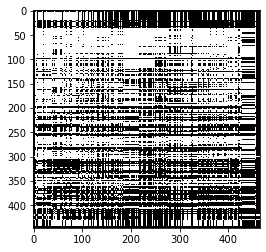

In [518]:

plt.imshow(Xr, cmap="Greys", interpolation="nearest")

In [468]:
js = """let albers_tie_up: boolean[] = [\n"""
for i, row in enumerate(B_opt):
    js += "\t["
    for j, elt in enumerate(row):
        js += "true" if elt else "false"
        if j < len(row) - 1:
            js += ", "
    js += "]"
    if i == B.T.shape[0] - 1:
        js += "];"
    else:
        js += ",\n"

In [469]:
print(js)

let face_tie_up: boolean[] = [
	[true, true, false, false, false, false, false, false, false, true, false, false, false, false, false, true],
	[true, true, true, false, false, false, false, false, false, false, false, false, false, false, false, false],
	[false, true, true, true, false, false, false, true, false, false, false, false, false, false, true, false],
	[false, false, true, true, true, false, false, false, false, false, false, false, false, false, false, false],
	[false, false, false, true, true, true, false, false, false, false, false, false, false, true, false, false],
	[false, false, false, false, true, true, true, false, false, true, false, false, false, false, false, false],
	[false, false, false, false, false, true, true, true, false, false, false, false, false, false, false, false],
	[false, true, false, true, false, false, true, true, true, false, false, false, false, false, false, false],
	[false, false, true, true, false, false, false, true, true, true, false, false,

In [533]:
%timeit  B_opt[A_idx[:, np.newaxis], C_idx] 

666 µs ± 2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [534]:
%timeit  A_opt @ B_opt @ C_opt

3.11 ms ± 19.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
